# Analisi Rollout: GRF vs MP vs Baseline

Questo notebook replica l'esperimento della Figura 4 del paper.
Confrontiamo la capacità dei tre modelli di mantenere una predizione fisicamente coerente nel tempo (Rollout) senza "guardare" la verità (Closed Loop).

**Metrica:** MSE (Mean Squared Error) delle coordinate 3D rispetto alla Ground Truth.

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from train import UnifiedInterlacer

# --- CONFIGURAZIONE ---
DATA_FOLDER = "./data/"
TEST_POINTS = "rollout_timestep.npy"
MODELS = {
    'Baseline': 'model_baseline.pth',
    'MP Interlacer': 'model_mp.pth',
    'GRF Interlacer': 'model_grf.pth'
}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
K_NEIGHBORS = 6
ROLLOUT_STEPS = 10  # Quanti step nel futuro predire (Paper usa 7-10)
NUM_TEST_SEQUENCES = 15  # Su quante sequenze diverse mediare i risultati (almeno ricuco le oscillazioni)

In [35]:
# --- FUNZIONI DI UTILITÀ ---

def compute_knn_torch(points, k):
    """Calcola KNN al volo su GPU per il closed loop"""
    B, N, D = points.shape
    x_sq = (points ** 2).sum(dim=-1, keepdim=True)
    y_sq = x_sq.transpose(1, 2)
    xy = torch.bmm(points, points.transpose(1, 2))
    dist_mat = x_sq + y_sq - 2 * xy
    _, knn_indices = torch.topk(dist_mat, k=k+1, dim=-1, largest=False)
    return knn_indices[:, :, 1:]

def load_model(path, mode):
    """Carica un modello salvato"""
    full_path = os.path.join(DATA_FOLDER, path)
    if not os.path.exists(full_path):
        print(f"Warning: {full_path} non trovato. Saltato.")
        return None, None, None
    
    checkpoint = torch.load(full_path, map_location=DEVICE, weights_only=False)
    # Use same architecture as training: embed_dim=64, num_layers=4
    # model = UnifiedInterlacer(mode=mode, embed_dim=64, num_layers=4).to(DEVICE)
    model = UnifiedInterlacer(mode=mode, embed_dim=128, num_layers=5).to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    mean = torch.tensor(checkpoint['mean']).to(DEVICE)
    std = torch.tensor(checkpoint['std']).to(DEVICE)
    return model, mean, std

In [36]:
# --- CARICAMENTO DATI ---
test_data_path = os.path.join(DATA_FOLDER, TEST_POINTS)
gt_points = np.load(test_data_path)
print(f"Dati di test caricati: {gt_points.shape}")

Dati di test caricati: (92, 1024, 3)


In [37]:
# --- ESECUZIONE ROLLOUT ---

results = {name: [] for name in MODELS.keys()}

# Selezioniamo indici di partenza casuali (ma con abbastanza spazio per il rollout)
start_indices = np.linspace(0, len(gt_points) - ROLLOUT_STEPS - 1, NUM_TEST_SEQUENCES, dtype=int)

# Soglia per considerare una predizione "corretta" (in unità normalizzate)
ACCURACY_THRESHOLD = 0.1

for model_name, model_file in MODELS.items():
    # Determina il mode dalla chiave o dal nome file
    if 'grf' in model_name.lower(): mode = 'grf'
    elif 'mp' in model_name.lower(): mode = 'mp'
    else: mode = 'baseline'
    
    print(f"Testando {model_name}...")
    model, mean, std = load_model(model_file, mode)
    
    if model is None: continue

    # Accumulatore accuracy per ogni timestep (da 0 a ROLLOUT_STEPS)
    accuracy_per_step = np.zeros(ROLLOUT_STEPS)
    
    with torch.no_grad():
        for start_idx in start_indices:
            # Prepara stato iniziale
            current_frame_np = gt_points[start_idx]
            current_frame = torch.from_numpy(current_frame_np).unsqueeze(0).to(DEVICE)
            current_frame = (current_frame - mean) / (std + 1e-6)
            
            for t in range(ROLLOUT_STEPS):
                # 1. Ground Truth futura per confronto
                gt_future_np = gt_points[start_idx + t + 1]
                
                # 2. Predizione Modello
                knn = compute_knn_torch(current_frame, K_NEIGHBORS)
                pred_next_norm = model(current_frame, knn)
                
                # 3. Denormalizza per calcolare errore reale
                pred_next_np = (pred_next_norm * (std + 1e-6) + mean).cpu().numpy().squeeze(0)
                
                # 4. Calcola Accuracy (percentuale di punti entro la soglia)
                # Distanza euclidea per ogni punto
                distances = np.linalg.norm(pred_next_np - gt_future_np, axis=-1)
                accuracy = np.mean(distances < ACCURACY_THRESHOLD) * 100  # Percentuale
                accuracy_per_step[t] += accuracy
                
                # 5. CLOSED LOOP: La predizione diventa l'input del prossimo step
                current_frame = pred_next_norm

    # Media sugli esempi di test
    results[model_name] = accuracy_per_step / NUM_TEST_SEQUENCES
    print(f"Finito {model_name}.")

Testando Baseline...
Finito Baseline.
Testando MP Interlacer...
Finito MP Interlacer.
Testando GRF Interlacer...
Finito GRF Interlacer.


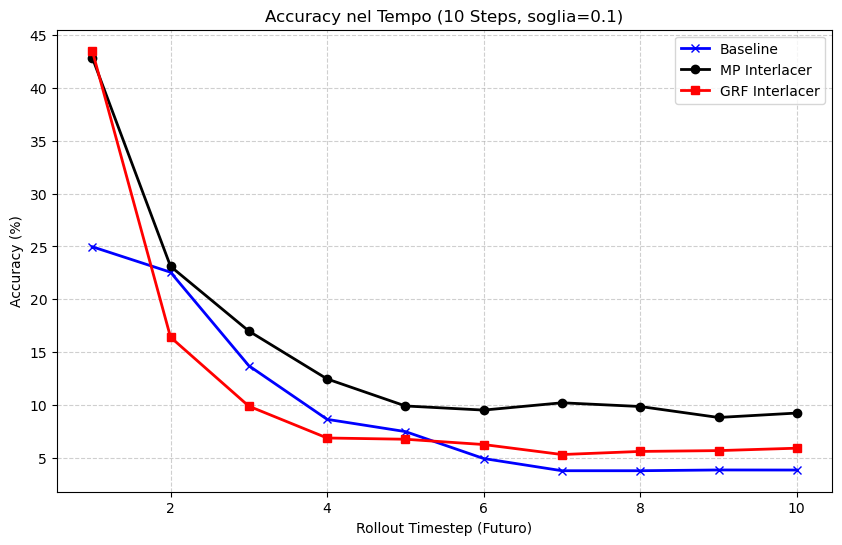

In [38]:
# --- PLOT RISULTATI ---
plt.figure(figsize=(10, 6))

markers = {'Baseline': 'x', 'MP Interlacer': 'o', 'GRF Interlacer': 's'}
colors = {'Baseline': 'blue', 'MP Interlacer': 'black', 'GRF Interlacer': 'red'}

for name, acc in results.items():
    if len(acc) == 0: continue
    plt.plot(range(1, ROLLOUT_STEPS + 1), acc, 
             marker=markers.get(name, 'o'), 
             color=colors.get(name, 'gray'),
             label=name, linewidth=2)

plt.title(f'Accuracy nel Tempo ({ROLLOUT_STEPS} Steps, soglia={ACCURACY_THRESHOLD})')
plt.xlabel('Rollout Timestep (Futuro)')
plt.ylabel('Accuracy (%)')
# plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()